## Word Embedding (GloVe) with LSTM 

In [2]:
import os
import pandas as pd
import numpy as np
import nltk
import gensim
import fasttext 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pickle
from pickle import load
from pickle import dump
from nltk import word_tokenize
from gensim.models.fasttext import FastText
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report

Using TensorFlow backend.


In [3]:
def create_word_lists(texts):
    corpus = []
    for text in texts:
        words = [word for word in word_tokenize(text)]
        corpus.append(words)
    return corpus

## Load data for model training 

In [4]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

#transform the label column to 0-4 since the first class starts at 0 for LSTM classification 
train['overall'] = train['overall'].apply(lambda x: (int(x)-1))
test['overall'] = test['overall'].apply(lambda x: (int(x)-1))

train.head()

,overall,department,clean2
0,0,Snack Foods,disappointed not crispy dense no spice find go...
1,2,"Herbs, Spices & Seasonings",st time purchase vanilla bean not overly impre...
2,2,Candy & Chocolate,love version dark chocolate thought salt carme...
3,4,"Herbs, Spices & Seasonings",convenient
4,1,Beverages,taste much like peach pie not enough like tea ...


In [5]:
#tokenize each review into list of words
train_corpus = create_word_lists(train['clean2'])
test_corpus = create_word_lists(test['clean2'])

#transform words in each review into number sequences 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_corpus)
dump(tokenizer, open('tokenizer_embed.pkl', 'wb'))
train_sequences = tokenizer.texts_to_sequences(train_corpus)
test_sequences = tokenizer.texts_to_sequences(test_corpus)


#find number of unique words 
word_index = tokenizer.word_index
print("Number of unique words: "+str(len(word_index)))
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size - '+str(vocab_size))

Number of unique words: 27018
vocab_size - 27019


In [6]:
max_length = 100

#pad the review sequences with 0's to max lengeth 
train_pad = pad_sequences(train_sequences, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')

train_ratings = train['overall'].values
test_ratings = test['overall'].values

#create idx to split train into train, val 
idx = np.arange(train_pad.shape[0])
np.random.shuffle(idx)
train_pad = train_pad[idx]
train_ratings = train_ratings[idx]

#create one-hot vector for class label 
n_values = np.max(train_ratings)+1

Y_train = np.eye(n_values)[train_ratings]
y_test = np.eye(n_values)[test_ratings]


In [7]:
val_split = 0.25

#create training and validation sets; 80% for train, 20% for validation 

num_validation_samples = int(val_split * train_pad.shape[0])

#validation set
X_val_pad = train_pad[:num_validation_samples]
y_val = Y_train[:num_validation_samples]

#train set 
X_train_pad = train_pad[num_validation_samples:]
y_train = Y_train[num_validation_samples:]


print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_val_pad:', X_val_pad.shape)
print('Shape of y_val:', y_val.shape)


print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (60000, 100)
Shape of y_train: (60000, 5)
Shape of X_val_pad: (20000, 100)
Shape of y_val: (20000, 5)
Shape of X_test_pad: (20000, 100)
Shape of y_test: (20000, 5)


## GloVe Model

In [45]:
# load the model and assign vectors to each word in the model 

embedding_glove = {}
embedding_dim_glove = 100

#open pre-trained word vector model
f = open(os.path.join(os.getcwd(),'glove_twitter_100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:], dtype='float32')
    embedding_glove[word] = vectors
f.close()

In [46]:
# take a look at the model 

print('Theere are:', len(embedding_glove), 'words in the model')
print("The embedding for food is", len(embedding_glove['food']), "dimensional")

embedding_glove['food']

Theere are: 1193514 words in the model
The embedding for food is 100 dimensional


array([-0.52348  , -0.39926  ,  0.24898  , -0.039715 ,  0.067344 ,
       -0.34445  ,  0.34888  ,  0.60016  ,  0.94921  , -0.64628  ,
       -1.1042   , -0.44242  , -4.2723   ,  0.47759  , -0.54165  ,
        0.55117  ,  0.26203  , -0.47045  , -0.37717  , -0.5985   ,
       -0.10843  ,  0.32041  , -0.40699  ,  0.004276 ,  0.5429   ,
        0.42808  , -0.16087  , -0.13919  ,  0.58994  ,  0.1809   ,
       -0.88564  , -0.047295 , -0.97389  , -0.0083825,  0.085801 ,
       -0.68881  ,  0.41937  ,  0.73735  ,  0.69426  ,  0.97459  ,
       -0.43348  ,  0.33125  ,  0.065084 , -0.13284  ,  0.99607  ,
        0.82727  ,  0.065382 ,  0.80963  , -0.095502 ,  0.049895 ,
       -0.77063  , -0.24953  , -0.76081  ,  0.91922  ,  0.20773  ,
        0.41041  ,  0.71853  , -0.22399  ,  0.2767   , -0.44373  ,
       -0.35005  , -0.15431  ,  0.013649 ,  0.38956  ,  0.32611  ,
       -0.84561  ,  0.27346  , -0.486    , -0.17267  , -0.081096 ,
       -0.30867  , -0.20255  ,  0.33779  ,  0.27343  ,  0.4622

In [47]:
# assign vector for each word in the corpus 

embedding_matrix_glove = np.zeros((vocab_size, embedding_dim_glove))
for word, i in word_index.items():
    embedding_vector = embedding_glove.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[i] = embedding_vector

In [48]:
# create embedding layer for LSTM model 

embedding_layer_glove = Embedding(vocab_size,
                            embedding_dim_glove,
                            weights=[embedding_matrix_glove],
                            input_length=max_length,
                            trainable=False)

In [49]:
# build model layers 

model_glove = Sequential()
model_glove.add(embedding_layer_glove)
model_glove.add(LSTM(units=100,  dropout=0.2, recurrent_dropout=0.25))
model_glove.add(Dense(5, activation='softmax'))

model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_glove.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2701900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 2,782,805
Trainable params: 80,905
Non-trainable params: 2,701,900
_________________________________________________________________
None


In [50]:
# run and store model history 

history_glove = model_glove.fit(X_train_pad, y_train, batch_size=64, epochs=80, 
                                validation_data=(X_val_pad, y_val), verbose=1)

Epoch 1/80
938/938 [==============================] - 215s 226ms/step - loss: 1.6098 - accuracy: 0.2050 - val_loss: 1.5785 - val_accuracy: 0.2313
Epoch 2/80
938/938 [==============================] - 210s 224ms/step - loss: 1.5936 - accuracy: 0.2334 - val_loss: 1.5630 - val_accuracy: 0.2458
Epoch 3/80
938/938 [==============================] - 214s 228ms/step - loss: 1.5637 - accuracy: 0.2463 - val_loss: 1.5709 - val_accuracy: 0.2386
Epoch 4/80
938/938 [==============================] - 213s 227ms/step - loss: 1.5681 - accuracy: 0.2381 - val_loss: 1.5617 - val_accuracy: 0.2410
Epoch 5/80
938/938 [==============================] - 211s 225ms/step - loss: 1.5699 - accuracy: 0.2418 - val_loss: 1.6069 - val_accuracy: 0.1994
Epoch 6/80
938/938 [==============================] - 206s 220ms/step - loss: 1.6062 - accuracy: 0.2058 - val_loss: 1.6098 - val_accuracy: 0.2002
Epoch 7/80
938/938 [==============================] - 210s 224ms/step - loss: 1.6103 - accuracy: 0.1975 - val_loss: 1.6116 -

Epoch 57/80
938/938 [==============================] - 128s 136ms/step - loss: 0.9243 - accuracy: 0.6030 - val_loss: 1.1480 - val_accuracy: 0.5234
Epoch 58/80
938/938 [==============================] - 129s 138ms/step - loss: 0.9303 - accuracy: 0.5991 - val_loss: 1.1610 - val_accuracy: 0.5217
Epoch 59/80
938/938 [==============================] - 131s 140ms/step - loss: 0.9180 - accuracy: 0.6047 - val_loss: 1.1615 - val_accuracy: 0.5256
Epoch 60/80
938/938 [==============================] - 127s 135ms/step - loss: 0.9157 - accuracy: 0.6075 - val_loss: 1.1530 - val_accuracy: 0.5250
Epoch 61/80
938/938 [==============================] - 127s 136ms/step - loss: 0.9233 - accuracy: 0.6001 - val_loss: 1.1547 - val_accuracy: 0.5232
Epoch 62/80
938/938 [==============================] - 133s 142ms/step - loss: 0.9146 - accuracy: 0.6110 - val_loss: 1.1597 - val_accuracy: 0.5225
Epoch 63/80
938/938 [==============================] - 129s 138ms/step - loss: 0.9151 - accuracy: 0.6092 - val_loss: 1

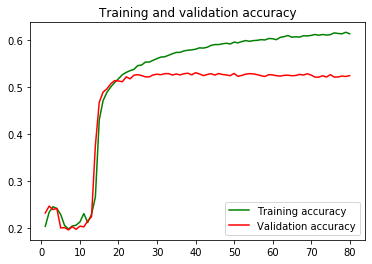

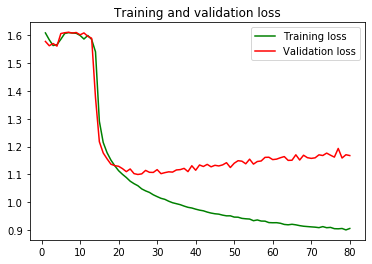

In [51]:
# plot training vs validation accuracy and loss 

acc = history_glove.history['accuracy']
val_acc = history_glove.history['val_accuracy']
loss = history_glove.history['loss']
val_loss = history_glove.history['val_loss']


epochs = range(1, len(acc)+1)


plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
# save the model 

model_glove.save('glove_LSTM.h5')

In [8]:
## load the model

glove = load_model('glove_LSTM.h5')

In [9]:
# predict on testing data 

y_pred_glove = glove.predict(X_test_pad)

In [10]:
# view results 

glove_results = classification_report(y_test.argmax(axis=1),y_pred_glove.argmax(axis=1))
print(glove_results)

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      3987
           1       0.43      0.43      0.43      3978
           2       0.46      0.42      0.44      4002
           3       0.48      0.49      0.48      4015
           4       0.63      0.70      0.67      4018

    accuracy                           0.53     20000
   macro avg       0.53      0.53      0.53     20000
weighted avg       0.53      0.53      0.53     20000



(5.0, 0.0)

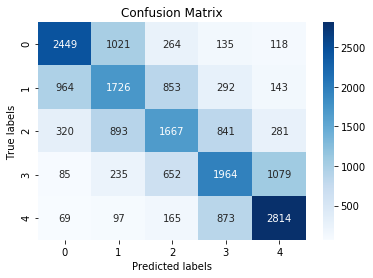

In [11]:
# plot confusion matrix 

cm_glove = confusion_matrix(y_test.argmax(axis=1), y_pred_glove.argmax(axis=1))

ax= plt.subplot()
sns.heatmap(cm_glove, annot=True, ax = ax, cmap=plt.cm.Blues, fmt="d"); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [13]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_glove.argmax(axis=1))
print(matrix)

actual, one_less, one_more  = 0, 0, 0
for i in range(len(matrix)):
    actual += matrix[i][i]
    try:
        one_less += matrix[i+1][i]
        one_more += matrix[i][i+1]
        i+=1
    except:
        one_less += 0
        one_more += 0
# print(actual, one_less, one_more)

acc_miss1 = (actual+one_less+one_more)/np.sum(matrix)
print('The accuracy with one missed step is:', acc_miss1)

[[2449 1021  264  135  118]
 [ 964 1726  853  292  143]
 [ 320  893 1667  841  281]
 [  85  235  652 1964 1079]
 [  69   97  165  873 2814]]
The accuracy with one missed step is: 0.8898


## Train customized FastText model based on 1.1 million reviews 

In [ ]:
# # model generation from all the reviews 

# m_df = pd.read_pickle("clean_df.pkl")

# # transform reviews into list of words 
# corpus = create_word_lists(m_df['clean2'])

# # Set values for various parameters
# feature_size = 100   # Word vector dimensionality  
# min_word_count = 3   # Minimum word count                        
# sample = 1e-3        # Downsample setting for frequent words


# #train fasttext model 
# ft_model = FastText(corpus, size=feature_size, 
#                      min_count = min_word_count, sample=sample, iter=200)

# ft_model.save("fasttext_amz.bin") # Saving the model

In [ ]:
# #load FastText model and review word vectors and examples 

# ft = FastText.load("fasttext_amz.bin") # Loading the model

# print('Example word vector', ft.wv['food'])

# print('Finding the most similar words', ft.wv.most_similar('bad'))



## Fasttext model with LSTM

In [ ]:
# # load the model and assign vectors to each word in the model 

# embedding_dim_ft = 100
# embedding_matrix_ft = np.zeros((vocab_size, embedding_dim_ft))
# for word, i in word_index.items():
#     embedding_vector = ft.wv[word]
#     if embedding_vector is not None:
#         embedding_matrix_ft[i] = embedding_vector

In [15]:
# # create embedding layer for LSTM model 

# embedding_layer_ft = Embedding(vocab_size, embedding_dim_ft, 
#                             weights=[embedding_matrix_ft], input_length=max_length, trainable=False)

In [ ]:
# # build model layers 

# model_ft = Sequential()
# model_ft.add(embedding_layer_ft)
# model_ft.add(LSTM(units=100,  dropout=0.2, recurrent_dropout=0.25))
# model_ft.add(Dense(5, activation='softmax'))

# model_ft.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# print(model_ft.summary())

In [ ]:
# run and store model history 

# history_ft = model_ft.fit(X_train_pad, y_train, batch_size=64, 
#                                 epochs=50, validation_data=(X_val_pad, y_val), verbose=1)

In [ ]:
## save the model

# model_ft.save('ft_LSTM.h5')

In [ ]:
# # load the model

# ft2 = load_model('ft_LSTM.h5')

In [ ]:
# # predict on test data 

# y_pred = ft2.predict(X_test_pad)

In [ ]:
# # view results 

# ft_results = classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1))
# print(ft_results)

In [ ]:
# # plot confusion matrix 

# cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax, cmap=plt.cm.Blues, fmt="d"); #annot=True to annotate cells
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
# #Custom word2vec model

# model = gensim.models.Word2Vec(sentences=corpus, size=100, window=5, workers=4, min_count=5, sg=1) #sg= 1:skip-gram 0:cbow
# vocab_words = list(model.wv.vocab)                                                                      
# print(len(vocab_words))

# filename = "amazon_word2vec_100.txt"
# model.wv.save_word2vec_format(filename, binary=False)